In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

In [2]:
from struct import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ucitavanje_slika(putanja):
    with open(putanja, "rb") as fp:
        magic_number = unpack(">I", fp.read(4))
        broj_slika = unpack(">I", fp.read(4))[0]
        broj_redova = unpack(">I", fp.read(4))[0]
        broj_kolona = unpack(">I", fp.read(4))[0]
        
        slike = np.frombuffer(fp.read(broj_slika*broj_redova*broj_kolona), dtype=np.uint8).reshape((broj_slika, broj_redova, broj_kolona))
        slike = slike.astype(np.float32)
        return slike

def ucitavanje_labela(putanja):
    with open(putanja, "rb") as fp:
        magic_number = unpack(">I", fp.read(4))
        broj_labela = unpack(">I", fp.read(4))[0]
        labele = np.frombuffer(fp.read(broj_labela), dtype=np.uint8)
        return labele

# train_slike = ucitavanje_slika("train-images.idx3-ubyte")
# train_labele = ucitavanje_labela("train-labels.idx1-ubyte")

# test_slike = ucitavanje_slika("t10k-images.idx3-ubyte")
# test_labele = ucitavanje_labela("t10k-labels.idx1-ubyte")

In [3]:
class MnistDataset(Dataset):
    def __init__(self, putanja_do_slika, putanja_do_labela):
        super().__init__()
        
        slike = ucitavanje_slika(putanja_do_slika)
        labele = ucitavanje_labela(putanja_do_labela)
        
        self.podaci = list(zip(slike.reshape(len(slike), slike[0].shape[0]*slike[0].shape[1]) , labele))
        # self.podaci = list(zip(slike.reshape(len(slike), 1, slike[0].shape[0], slike[0].shape[1]) , labele))
    
    def __getitem__(self, indeks):
        return self.podaci[indeks]
    
    def __len__(self):
        return len(self.podaci)

In [4]:
train_dataset = MnistDataset("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_dataset = MnistDataset("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

In [5]:
train_podaci = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_podaci = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [6]:
class Mreza(nn.Module):
    def __init__(self):
        super().__init__()
        self.prvi_sloj = nn.Linear(28*28, 400)
        self.drugi_sloj = nn.Linear(400, 200)
        self.treci_sloj = nn.Linear(200, 100)
        self.cetvrti_sloj = nn.Linear(100, 10)
        
    def forward(self, x):
        prvi_sloj_izlaz = F.tanh(self.prvi_sloj(x))
        drugi_sloj_izlaz = F.tanh(self.drugi_sloj(prvi_sloj_izlaz))
        treci_sloj_izlaz = F.tanh(self.treci_sloj(drugi_sloj_izlaz))
        cetvrti_sloj_izlaz = F.tanh(self.cetvrti_sloj(treci_sloj_izlaz))
        return cetvrti_sloj_izlaz

In [7]:
mreza = Mreza()

funkcija_greske = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mreza.parameters(), lr=0.0001, momentum=0.9)

broj_epoha = 10

for i in range(broj_epoha):
    for (x, y) in train_podaci:
        yp = mreza(x)
        
        optimizer.zero_grad()
        greska = funkcija_greske(yp, y)
        greska.backward()
        optimizer.step()
    print(i)

0
1
2
3
4
5
6
7
8
9


In [8]:
tacnih = 0
for p in test_podaci:
    y = torch.argmax(mreza(p[0]), 1)
    tacnih += (p[1] == y).sum()

print(tacnih/len(test_dataset))

tensor(0.9260)


In [9]:
class MnistDataset(Dataset):
    def __init__(self, putanja_do_slika, putanja_do_labela):
        super().__init__()
        
        slike = ucitavanje_slika(putanja_do_slika)
        labele = ucitavanje_labela(putanja_do_labela)
        
        self.podaci = list(zip(slike.reshape(len(slike), 1, slike[0].shape[0], slike[0].shape[1]) , labele))
    
    def __getitem__(self, indeks):
        return self.podaci[indeks]
    
    def __len__(self):
        return len(self.podaci)

train_podaci = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_podaci = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [10]:
train_dataset = MnistDataset("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_dataset = MnistDataset("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

In [11]:
train_podaci = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_podaci = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [12]:
class CNNMreza(nn.Module):
    def __init__(self):
        super().__init__()
        self.prvi_sloj = nn.Conv2d(1, 5, 3, padding=1)
        self.drugi_sloj = nn.Conv2d(5, 10, 3, padding=1)
        
        self.linearni1 = nn.Linear(10*28*28, 500)
        self.linearni2 = nn.Linear(500, 10)
    
    def forward(self, x):
        prvi_sloj_izlaz = F.tanh(self.prvi_sloj(x))
        drugi_sloj_izlaz = F.tanh(self.drugi_sloj(prvi_sloj_izlaz))
        linearni1_izlaz = F.tanh(self.linearni1(drugi_sloj_izlaz.view(-1, 10*28*28)))
        linearni2_izlaz = F.tanh(self.linearni2(linearni1_izlaz))
        return linearni2_izlaz

In [13]:
cnn_mreza = CNNMreza()

funkcija_greske = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_mreza.parameters(), lr=0.0001, momentum=0.9)

broj_epoha = 2

for i in range(broj_epoha):
    for (x, y) in train_podaci:
        yp = cnn_mreza(x)
        
        optimizer.zero_grad()
        greska = funkcija_greske(yp, y)
        greska.backward()
        optimizer.step()
    print(i)

0
1


In [14]:
tacnih = 0
for p in test_podaci:
    y = torch.argmax(cnn_mreza(p[0]), 1)
    tacnih += (p[1] == y).sum()

In [15]:
print(tacnih)
print(tacnih/len(test_dataset))

tensor(9605)
tensor(0.9605)


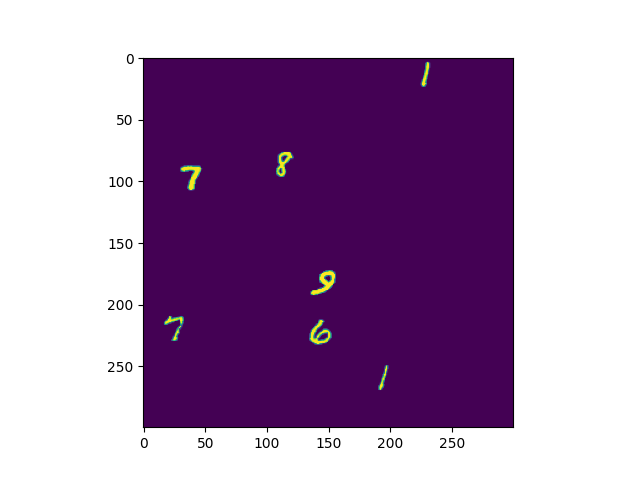

In [16]:
%matplotlib widget

slika = np.zeros((300, 300))

koordinate_cifara = np.random.randint(0, 300-28, size=(7, 2))

for k in koordinate_cifara:
    slika_cifre = iter(test_podaci).__next__()
    cifra, labela = slika_cifre[0][0], slika_cifre[1][0]
    slika[k[0]:k[0]+28, k[1]:k[1]+28] += cifra.numpy().reshape(28, 28)

slika = np.where(slika > 255, 255, slika)
    
plt.figure()
plt.imshow(slika)
plt.show()

In [17]:
rezultat = np.zeros((300, 300))

for i in range(0, 300-28, 1):
    for j in range(0, 300-28, 1):
        deo_slike = torch.from_numpy(slika[i:i+28, j:j+28].astype(np.float32).reshape(1, 28, 28))
        predikcija = cnn_mreza(deo_slike).max() > 0.9
        if predikcija == True:
            rezultat[i:i+28, j:j+28] += 1

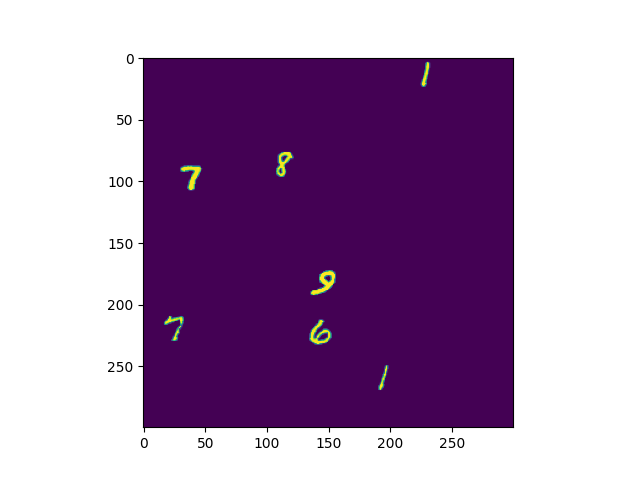

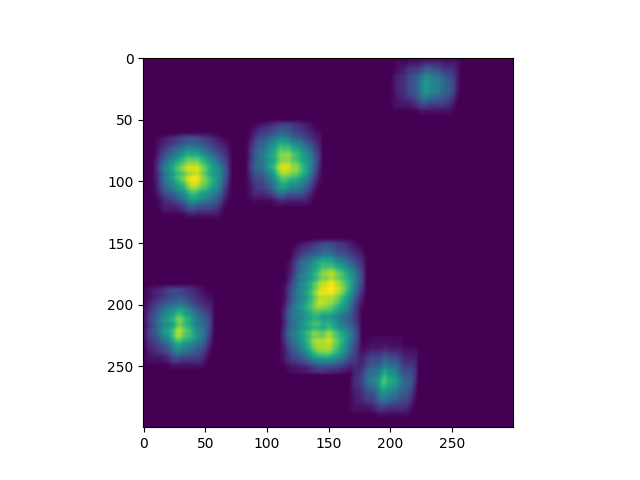

In [18]:
plt.figure()
plt.imshow(slika)
plt.show()

plt.figure()
plt.imshow(rezultat)
plt.show()

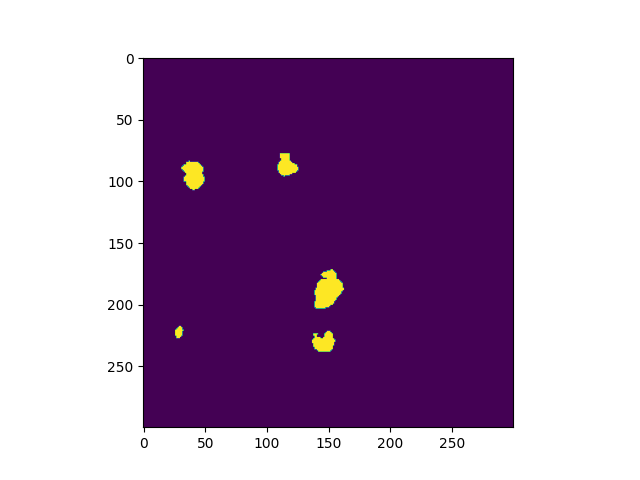

In [19]:
rezultat_binarno = rezultat > 400

plt.figure()
plt.imshow(rezultat_binarno)
plt.show()

In [20]:
rezultat = np.zeros((10, 300, 300))

for i in range(0, 300-28, 1):
    for j in range(0, 300-28, 1):
        deo_slike = torch.from_numpy(slika[i:i+28, j:j+28].astype(np.float32).reshape(1, 28, 28))
        predikcija = cnn_mreza(deo_slike)
        cifra = predikcija.argmax()
        if predikcija[0][cifra] > 0.9:
            rezultat[cifra, i:i+28, j:j+28] += 1

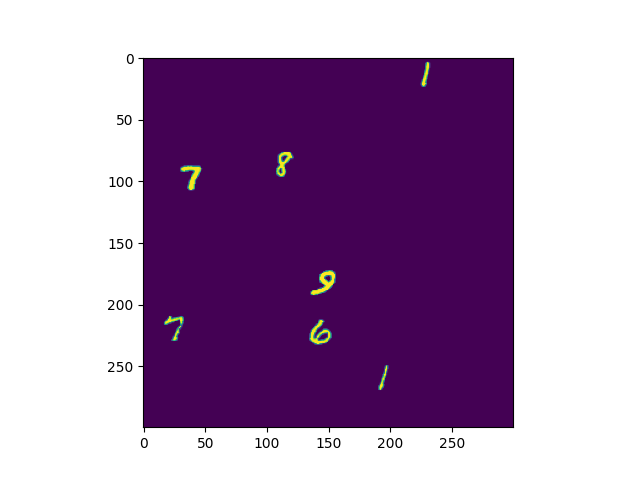

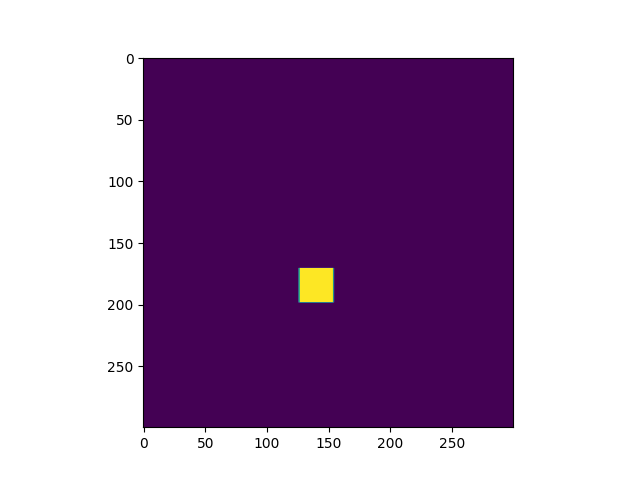

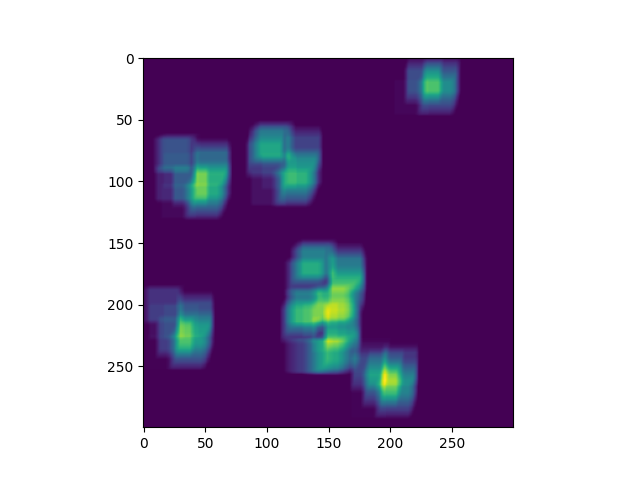

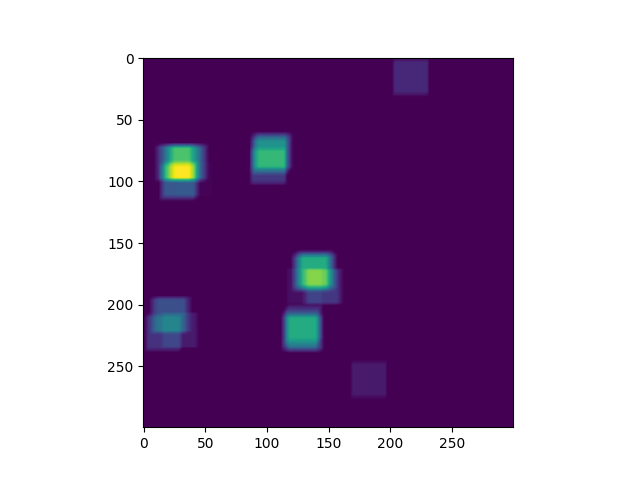

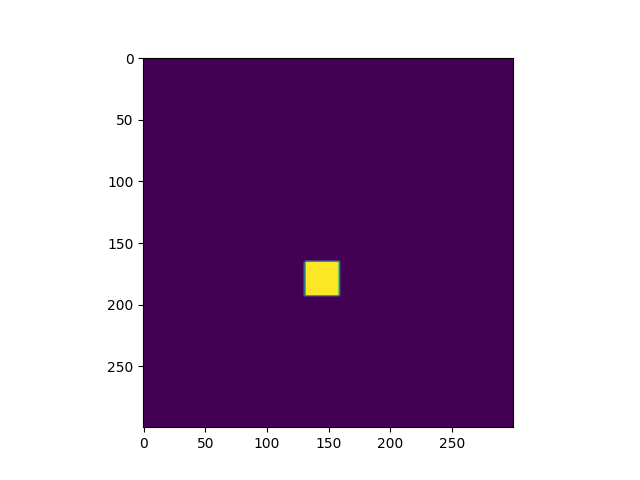

C:\Users\Ivan\AppData\Local\Temp\ipykernel_15852\46471880.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


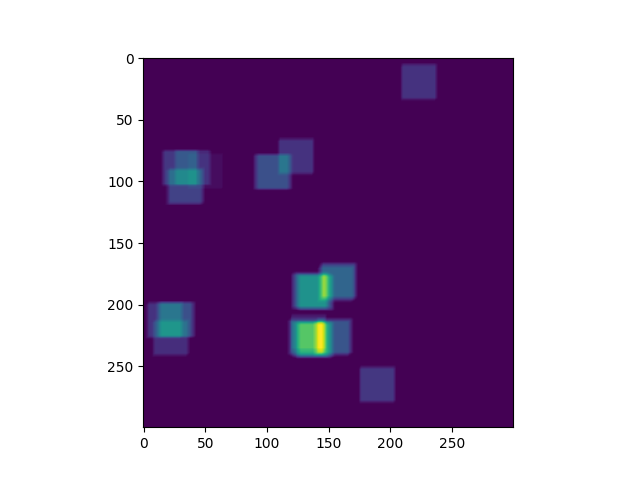

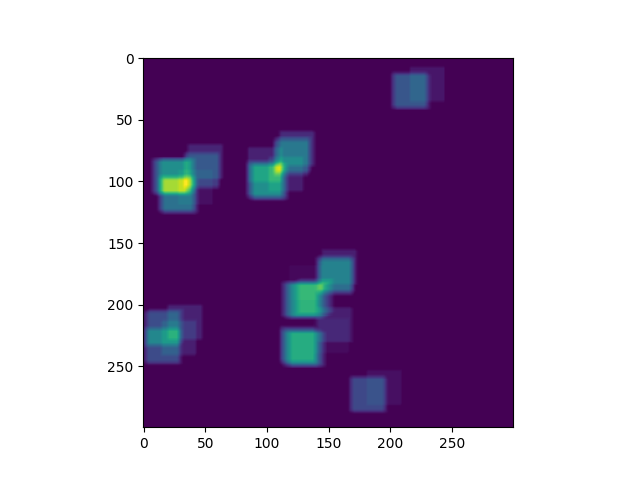

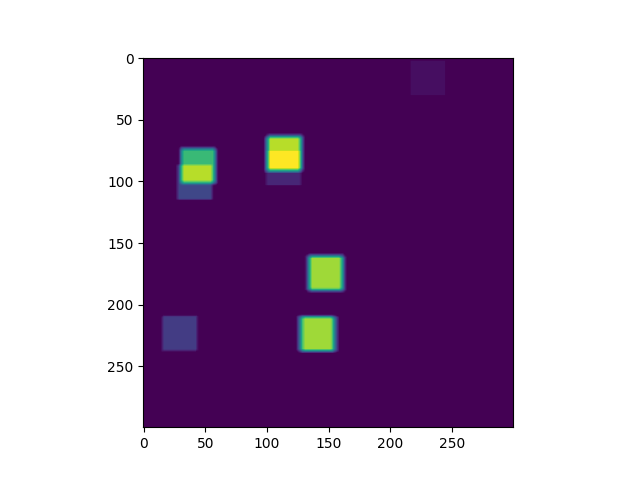

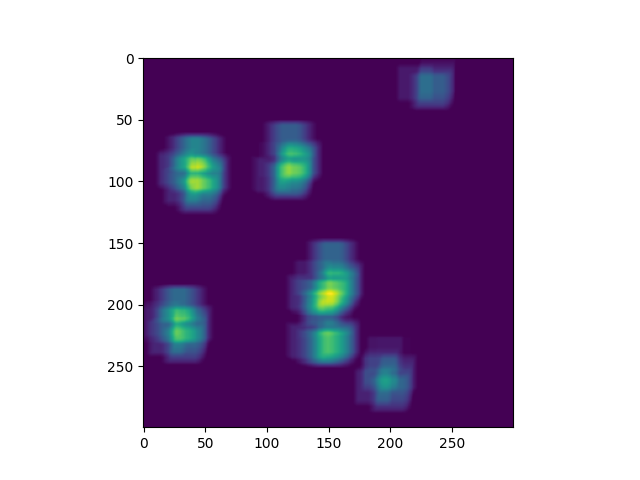

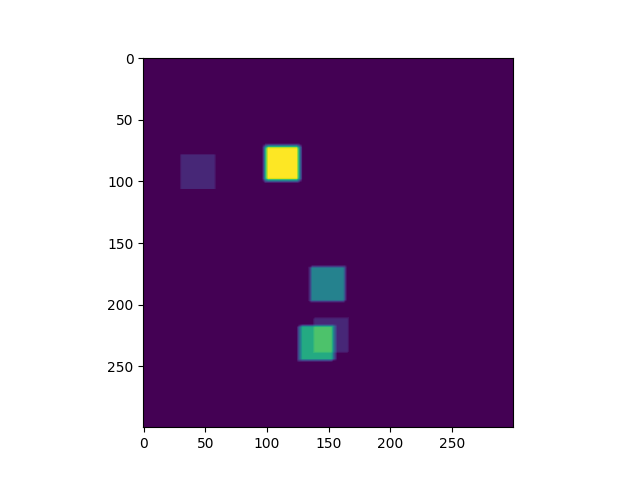

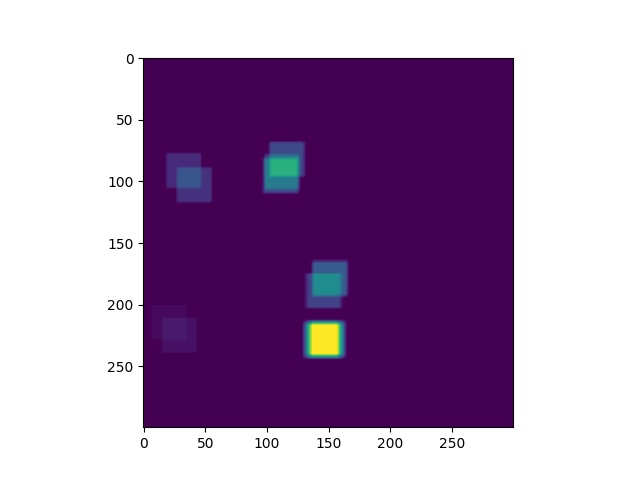

In [22]:
plt.figure()
plt.imshow(slika)
plt.show()

for i in range(0, 10):
    plt.figure()
    plt.imshow(rezultat[i])
    plt.show()